## Use SX5E and bloomberg download data to get me started

In [480]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [436]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [437]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Reported EPS','Comp EPS','Consensus EPS','50d MA','3d return','Volume','Momentum',
             'Revision','Market cap','PE','property','Price']

data_dict={}

for s in tabs_to_grab:
    data_dict[s]=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result code\Catalyst.xlsx',sheet_name=s))

In [438]:
#signal formation (number 1) and use the date as the base dataframe
signal=data_dict['Date'][(data_dict['3d return']>2) & (data_dict['Revision']>0.02)]
signal=signal.dropna(axis=1,how='all')
signal=signal.dropna(axis=0,how='all')

In [441]:
#Stack signals into a list of tuples (stocks, dates), convert dates into a common format of datetime
signal_list=[]
for index, row in signal.iterrows():
    adj_row=row.dropna()
    for s in adj_row.values:
        ts=(s - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') 
        adj_time=datetime.utcfromtimestamp(ts).strftime("%d/%b/%Y") #transform the datetime into a common format
        signal_list.append((adj_row.name,adj_time))

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


In [505]:
# grab the price time series and transform it into the same datetime format; also generate abs_return, rel_return dataframe
price=data_dict["Price"]
new_column=pd.to_datetime(price.columns).strftime("%d/%b/%Y").tolist()
price.columns=new_column

abs_return=price.diff(1,axis=1)/price
abs_return=abs_return.dropna(how='all',axis=1)
rel_return=abs_return - abs_return.iloc[-1]
rel_return=rel_return.dropna(how='all',axis=1)

In [572]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal_return_dict(signal_list,return_dataframe,holding):
    signal_dict={}
    for s in signal_list:
        return_series=return_dataframe.loc[s[0]]
        day0=return_series.index.tolist().index(s[1]) #index of day 0
        target_series=return_series.iloc[day0:day0+min(holding, len(return_series[day0:]))]
        target_series.index=range(min(holding, len(return_series[day0:]))) #replace datetime with number of days post announcement
        target_series.name=s
        signal_dict[s]=target_series
    return signal_dict


In [579]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal_return_df(signal_list,return_dataframe,holding):
    return_series_list=[]
    return_dict=signal_return_dict(signal_list,return_dataframe,holding)
    for index,key in return_dict.items():
        return_series_list.append(key)
    return_df=pd.concat(return_series_list,axis=1)
    return_df=return_df.dropna(how='any',axis=1) #drop stocks with limited history to make it more comparable
    return return_df

abs_return_df=signal_return_df(signal_list,abs_return,123)
rel_return_df=signal_return_df(signal_list,rel_return,123)

In [580]:
# List of signals and cumulative returns
ind_abs_return=abs_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
ind_abs_return

ind_rel_return=rel_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
ind_rel_return

ADS GY    08/Mar/2017    0.033548
ALV GY    16/Feb/2017    0.091166
ASML NA   19/Jul/2017    0.093027
          19/Oct/2016    0.144697
BMW GY    03/Aug/2017    0.118280
          04/May/2017   -0.039345
CRH ID    25/Aug/2016   -0.010643
DG FP     07/Feb/2017    0.067937
DPW GY    11/May/2016    0.031508
DTE GY    03/Aug/2017   -0.133005
ENGI FP   02/Mar/2017    0.093085
ENI IM    28/Jul/2017    0.053168
FP FP     11/Feb/2016    0.024361
GLE FP    03/Nov/2016    0.155430
          03/Aug/2016    0.316157
IBE SQ    22/Feb/2017    0.055520
INGA NA   03/Nov/2016    0.046876
          03/Aug/2016    0.191740
MUV2 GY   09/Aug/2016    0.038575
NOKIA FH  02/Feb/2017    0.134540
PHIA NA   24/Oct/2016   -0.043749
SAN FP    28/Oct/2016    0.037927
SAN SQ    25/Jan/2017    0.028812
SIE GY    04/Aug/2016    0.050622
          04/May/2016    0.097536
          25/Jan/2016    0.060011
TEF SQ    23/Feb/2017   -0.040833
VIV FP    31/Aug/2017    0.019270
          09/Nov/2016   -0.217079
Name: 122, dty

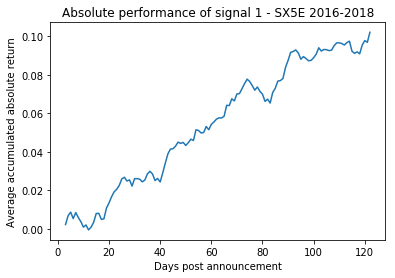

In [575]:
# Performance analytics
# 1. aggregate abs/rel performance over time
def perf_chart(return_df,xlabel,ylabel,title):
    cum_return=return_df.mean(axis=1).cumsum()
    plt.plot(cum_return)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
perf_chart(abs_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated absolute return",title="Absolute performance of signal 1 - SX5E 2016-2018")

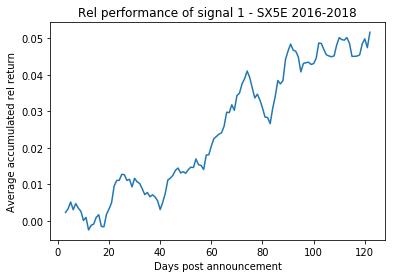

In [576]:
perf_chart(rel_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated rel return",title="Rel performance of signal 1 - SX5E 2016-2018")


In [577]:
# 2. trading analytics
def trading_analytics(return_df):
    ind_return=return_df.cumsum(axis=0).iloc[-1]
    hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
    payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
    #annualised_return=return_df.mean(axis=1).cumsum().iloc[-1]*260/(len(return_df))
    #annualised_vol=return_df.mean(axis=1).std()*((260/(len(return_df)))**0.5)
    #annualised_sharpe=annualised_return/annualised_vol*1.0
    return hit_rate,payoff_ratio
    
trading_analytics(rel_return_df[3:]) 


(0.7931034482758621, 1.0677993726103472)